## Test the Computation of angles between CLVs

In [50]:
######################
##	Library Imports
######################
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import jit

In [55]:
@jit(nopython = True)
def compute_angles(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                angles[t, i, j] = np.arccos(np.absolute(np.dot(CLV[t, :, i], CLV[t, :, j])))
    
    return angles

### Work

In [102]:
dof = 3
rho = 28
dt  = 0.0005
m_iter = 1
trans  = 100
m_avg  = 60000000

In [103]:
## Read open data file
results_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Lyapunov_Analysis/Strange_Attractors/Data"
filename    = "/LorenzData_RHO[{:0.2f}]_TSTEP[{:0.6f}]_INTSTEPS[{}]_TRANSSTEPS[{}]_AVGSTEPS[{}].h5".format(rho, dt, m_iter, trans, m_avg)

input_dir  = results_dir
output_dir = results_dir

In [104]:
HDFfileData = h5py.File(input_dir + filename, 'r')
print("\n\nData File: {}.h5\n".format(filename))
list(HDFfileData.keys())



Data File: /LorenzData_RHO[28.00]_TSTEP[0.000500]_INTSTEPS[1]_TRANSSTEPS[100]_AVGSTEPS[60000000].h5.h5



['Angles', 'CLVs', 'LCE', 'PhaseSpace', 'Time']

In [105]:
angles = HDFfileData['Angles']
CLVs   = HDFfileData['CLVs']
time   = HDFfileData['Time'][:]

clv_dims = CLVs.attrs['CLV_Dims']
CLV      = np.reshape(CLVs, (np.append(CLVs.shape[0], clv_dims[0, :])))
print(CLV.shape)
angle_dims = angles.attrs['Angle_Dims']
angles      = np.reshape(angles, (np.append(angles.shape[0], angle_dims[0, :])))
print(angles.shape)

num_tsteps = len(time);
HDFfileData.close()

(59999900, 3, 3)
(59999900, 3, 3)


In [106]:
angles_py = compute_angles(CLV, num_tsteps - trans, dof)
print(angles_py.shape)

(59999900, 3, 3)


In [107]:
print(sum(np.isnan(angles)))
angles[-1, :, :]

[[0 0 0]
 [0 0 0]
 [0 0 0]]


array([[0.        , 0.        , 0.        ],
       [0.57976012, 0.        , 0.        ],
       [1.32682934, 0.77048805, 0.        ]])

In [108]:
print(sum(np.isnan(angles_py)))
angles_py[-1, :, :]

[[      0       0       0]
 [2301983       0       0]
 [1363884 9108606       0]]


array([[0.        , 0.        , 0.        ],
       [1.57079633, 0.        , 0.        ],
       [1.57079633, 1.17037172, 0.        ]])

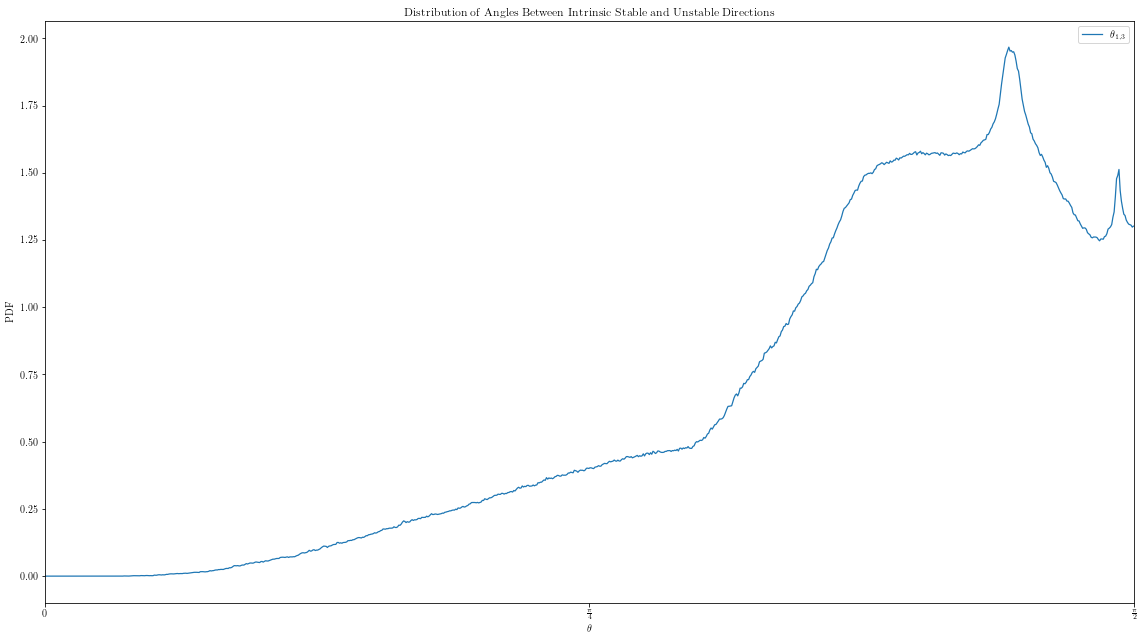

In [109]:
plt.figure()
hist, bins  = np.histogram(angles[:, 2, 0], range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
# hist, bins  = np.histogram(angles[:, 1, 0], range = (0.0, np.pi / 2.0), bins = 900, density = True);
# bin_centers = (bins[1:] + bins[:-1]) * 0.5
# plt.plot(bin_centers, hist)
# hist, bins  = np.histogram(angles[:, 2, 1], range = (0.0, np.pi / 2.0), bins = 900, density = True);
# bin_centers = (bins[1:] + bins[:-1]) * 0.5
# plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 3}$", r"$\theta_{1,2}$", r"$\theta_{2,3}$"])
plt.ylabel(r"PDF")
plt.title(r"Distribution of Angles Between Intrinsic Stable and Unstable Directions")
plt.show()